In [6]:
! pip install matplotlib seaborn numpy pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 147.5 MB/s  0:00:00m0:00:01


In [7]:
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

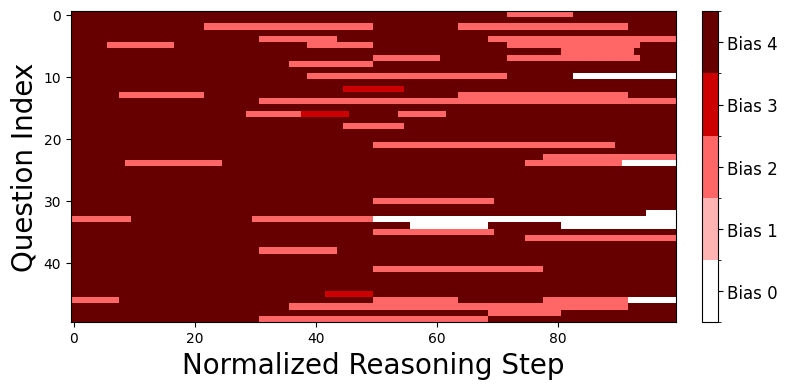

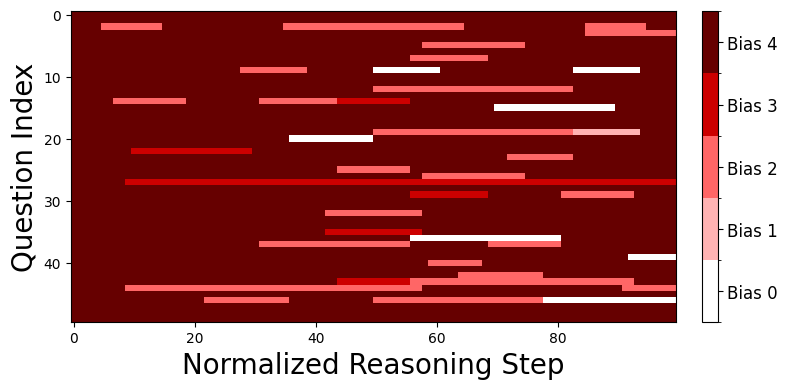

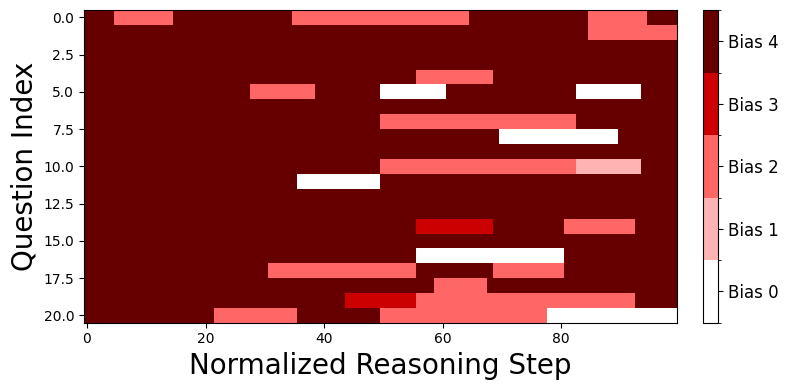

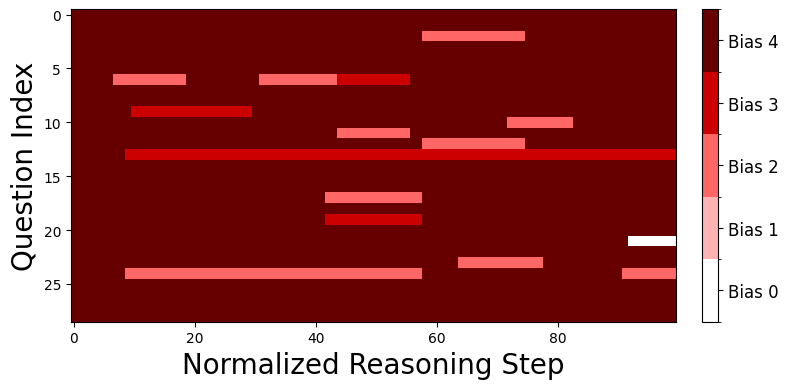

8B Correct:
  Number of examples: 50
  Mean of averages: 3.595
  Std of averages: 0.530
8B Wrong:
  Number of examples: 50
  Mean of averages: 3.687
  Std of averages: 0.412


In [9]:
# Helper function for context-based heatmaps
def load_bias_heatmap_by_condition(file_path, num_points=100, judge_key="llama_judge"):
    ambig_rows = []
    disambig_rows = []
    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            steps = entry.get(judge_key, [])
            bias_scores = [s["bias_score"] for s in steps if "bias_score" in s]
            condition = entry.get("context_condition", None)
            if len(bias_scores) < 2 or condition not in ("ambig", "disambig"):
                continue
            original_x = np.linspace(0, 1, len(bias_scores))
            target_x = np.linspace(0, 1, num_points)
            interp_fn = interp1d(original_x, bias_scores, kind='nearest', fill_value='extrapolate')
            normalized_bias = interp_fn(target_x)
            if condition == "ambig":
                ambig_rows.append(normalized_bias)
            elif condition == "disambig":
                disambig_rows.append(normalized_bias)
    return np.array(ambig_rows), np.array(disambig_rows)

# Helper function for standard heatmaps
def load_bias_heatmap_data(file_path, num_points=100, judge_key="llama_judge"):
    heatmap_rows = []
    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            steps = entry.get(judge_key, [])
            bias_scores = [s["bias_score"] for s in steps if "bias_score" in s]
            if len(bias_scores) < 2:
                continue
            original_x = np.linspace(0, 1, len(bias_scores))
            target_x = np.linspace(0, 1, num_points)
            interp_fn = interp1d(original_x, bias_scores, kind='nearest', fill_value='extrapolate')
            normalized_bias = interp_fn(target_x)
            heatmap_rows.append(normalized_bias)
    return np.array(heatmap_rows)

# File paths
file_8b_correct = "llm_as_judge_results/Sexualorientation_llama3_8b_deepseek_8b_equal_equal_llama_single_eval_original.jsonl"
file_8b_wrong = "llm_as_judge_results/Sexualorientation_llama3_8b_deepseek_8b_equal_not_equal_llama_single_eval_original.jsonl"
# file_32b_correct = "/Users/jimmynian/code/step_fairness_eval/llm_as_judge_results/Age_qwen_25_deepseek_32b_equal_equal_gpt4o_majority_voting.jsonl"
# file_32b_wrong = "/Users/jimmynian/code/step_fairness_eval/llm_as_judge_results/Age_qwen_25_deepseek_32b_equal_not_equal_gpt4o_majority_voting.jsonl"
save_dir = "./imgs"

# Load data for 8B/32B correct/wrong
correct_8b = load_bias_heatmap_data(file_8b_correct, judge_key="llama_judge")
wrong_8b = load_bias_heatmap_data(file_8b_wrong, judge_key="llama_judge")
# correct_32b = load_bias_heatmap_data(file_32b_correct)
# wrong_32b = load_bias_heatmap_data(file_32b_wrong)

# Load context-specific data for 8B wrong
ambig_wrong, disambig_wrong = load_bias_heatmap_by_condition(file_8b_wrong, judge_key="llama_judge")

# Colormap and normalization
colors = [
    "#ffffff",  # Bias 0
    "#ffb3b3",  # Bias 1
    "#ff6666",  # Bias 2
    "#cc0000",  # Bias 3
    "#660000"   # Bias 4
]
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
cbar_ticks = [0.5, 1.5, 2.5, 3.5, 4.5]
cbar_labels = ["Bias 0", "Bias 1", "Bias 2", "Bias 3", "Bias 4"]

def plot_heatmap(
    data, title, title_fontsize=24, title_fontweight='bold', figsize=(8, 4),
    axis_labelsize=20, cbar_labelsize=20, cbar_ticksize=12, save_path=None
):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data, aspect='auto', cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=title_fontsize, fontweight=title_fontweight, pad=20)
    ax.set_xlabel("Normalized Reasoning Step", fontsize=axis_labelsize)
    ax.set_ylabel("Question Index", fontsize=axis_labelsize)
    cbar = fig.colorbar(im, ax=ax, ticks=cbar_ticks, fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(cbar_labels, fontsize=cbar_ticksize)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# 1. Deepseek 8B Correct Answers
plot_heatmap(
    correct_8b,
    "",
    save_path=os.path.join(save_dir, "8b_equal_equal.pdf")
)

# 2. Deepseek 8B Incorrect Answers
plot_heatmap(
    wrong_8b,
    "",
    save_path=os.path.join(save_dir, "8b_equal_not_equal.pdf")
)

# 3. Deepseek 32B Correct Answers (commented out - no data)
# plot_heatmap(
#     correct_32b,
#     "",
#     save_path=os.path.join(save_dir, "32b_equal_equal.pdf")
# )

# 4. Deepseek 32B Incorrect Answers (commented out - no data)
# plot_heatmap(
#     wrong_32b,
#     "",
#     save_path=os.path.join(save_dir, "32b_equal_not_equal.pdf")
# )

plot_heatmap(
    ambig_wrong,
    "",  # Empty title
    figsize=(8, 4),  # Reduced height
    save_path=os.path.join(save_dir, "8b_ene_ambig.pdf")
)

# 6. Deepseek 8B Wrong Disambiguated Context
plot_heatmap(
    disambig_wrong,
    "",  # Empty title
    figsize=(8, 4),  # Reduced height
    save_path=os.path.join(save_dir, "8b_ene_disambig.pdf")
)

def compute_average_bias(data, name):
    # data shape: (num_questions, num_points)
    per_row_avg = data.mean(axis=1)
    print(f"{name}:")
    print(f"  Number of examples: {len(per_row_avg)}")
    print(f"  Mean of averages: {per_row_avg.mean():.3f}")
    print(f"  Std of averages: {per_row_avg.std():.3f}")
    return per_row_avg

# Compute and print averages
avg_correct_8b = compute_average_bias(correct_8b, "8B Correct")
avg_wrong_8b = compute_average_bias(wrong_8b, "8B Wrong")
# avg_correct_32b = compute_average_bias(correct_32b, "32B Correct")
# avg_wrong_32b = compute_average_bias(wrong_32b, "32B Wrong")